<a href="https://colab.research.google.com/github/Zamoca42/TIL/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 최종프로젝트 설명

자신의 얼굴 인식하는 인공신경망 만들기

1. 자신의 얼굴사진과 타인 1명 얼굴사진을 10장 이상 수집

2. 본인이 정한 크기로 얼굴이 잘 나오게 크롭 혹은 resizing (192 * 144).  
(Train dataset과 Label dataset으로 python에서 읽기)

3. 수업시간에 배운 CNN을 제작 후, input_shape 등을 잘 맞춰서 학습시키기

4. 학습되지 않은 새로운 사진을 가지고 테스트

- 이미지 전처리(Preprocessing)
  - https://www.tensorflow.org/tutorials/load_data/images
  - https://keras.io/api/data_loading/image/#load_img-function
- 이미지 증강(data_augmentation)
  - https://www.tensorflow.org/tutorials/images/data_augmentation


  ```
  project directory
  
  ProjectPhoto
    ∟ train
        ⊢ celeb
        ∟ me
  ```


In [ ]:
import numpy as np
import tensorflow as tf
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 기본 경로

# base_dir = '/content/drive/MyDrive/ProjectPhoto'
# train_dir = os.path.join(base_dir, 'train')

train_dir = '/content/drive/MyDrive/ProjectPhoto/train'

In [ ]:
# 이미지 전처리하기
# 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

batch_size = 57
img_height = 192
img_width = 144

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed = 50,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed = 50,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names

print(class_names)
print(len(class_names))

Found 57 files belonging to 2 classes.
Using 46 files for training.
Found 57 files belonging to 2 classes.
Using 11 files for validation.
['celeb', 'me']
2


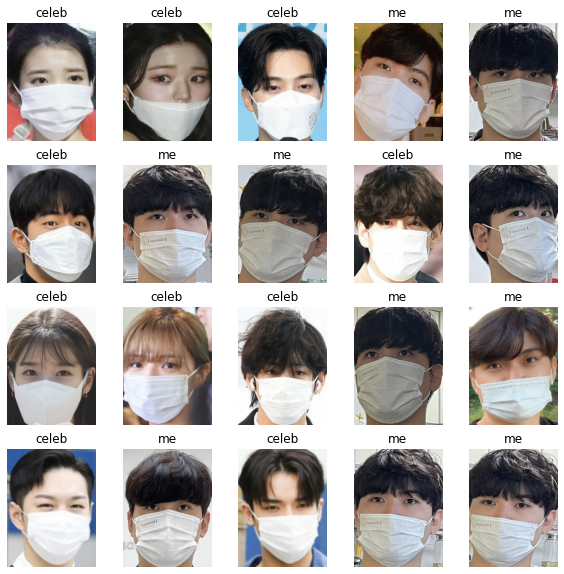

In [ ]:
import matplotlib.pyplot as plt

# 랜덤 사진 20장 확인

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# 성능을 높이도록 데이터세트 구성
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 이미지 증강
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(46, 192, 144, 3)
(46,)


In [ ]:
# 모델 훈련하기

num_classes = len(class_names)

model = Sequential([
    # Augmentation & Rescaling
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Normalization(axis=-1),
    # Convolution
    layers.Conv2D(16, 3, padding='same', activation='relu'), # input_shape=(192, 144, 3)
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    # Flatten
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    verbose=2)

Epoch 1/100
1/1 - 1s - loss: 0.1812 - accuracy: 0.9130 - val_loss: 2.0875 - val_accuracy: 0.3636 - 1s/epoch - 1s/step
Epoch 2/100
1/1 - 0s - loss: 1.4973 - accuracy: 0.5000 - val_loss: 0.2877 - val_accuracy: 0.9091 - 68ms/epoch - 68ms/step
Epoch 3/100
1/1 - 0s - loss: 0.3091 - accuracy: 0.8913 - val_loss: 0.2593 - val_accuracy: 0.9091 - 78ms/epoch - 78ms/step
Epoch 4/100
1/1 - 0s - loss: 0.3391 - accuracy: 0.8261 - val_loss: 0.3835 - val_accuracy: 0.8182 - 70ms/epoch - 70ms/step
Epoch 5/100
1/1 - 0s - loss: 0.5020 - accuracy: 0.7391 - val_loss: 0.3368 - val_accuracy: 0.8182 - 69ms/epoch - 69ms/step
Epoch 6/100
1/1 - 0s - loss: 0.3617 - accuracy: 0.8261 - val_loss: 0.2734 - val_accuracy: 0.9091 - 75ms/epoch - 75ms/step
Epoch 7/100
1/1 - 0s - loss: 0.3016 - accuracy: 0.8696 - val_loss: 0.2449 - val_accuracy: 0.9091 - 71ms/epoch - 71ms/step
Epoch 8/100
1/1 - 0s - loss: 0.2973 - accuracy: 0.8913 - val_loss: 0.2776 - val_accuracy: 0.9091 - 70ms/epoch - 70ms/step
Epoch 9/100
1/1 - 0s - loss:

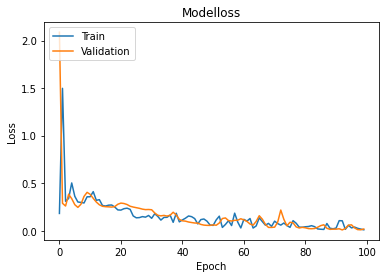

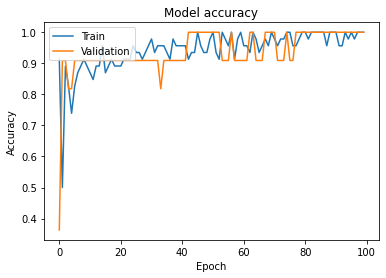

In [ ]:
# 플롯

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

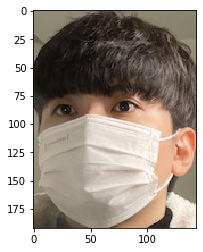

1/1 [==============================] - 0s 76ms/step
This image most likely belongs to me with a 71.45 percent confidence.


In [ ]:
test_path = '/content/drive/MyDrive/ProjectPhoto/test.jpeg'

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img, interpolation='nearest')
plt.show()

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

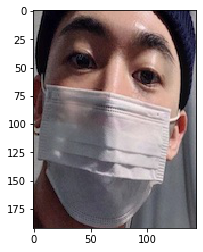

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to celeb with a 71.72 percent confidence.


In [ ]:
test_path = '/content/drive/MyDrive/ProjectPhoto/test2.jpg'

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
plt.imshow(img, interpolation='nearest')
plt.show()

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# 모델 저장
model.save("/content/drive/MyDrive/Project_gpu_ver6.h5")